## Tampa Bay, FL - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Tampa Bay, FL into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Tampa Bay, FL

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

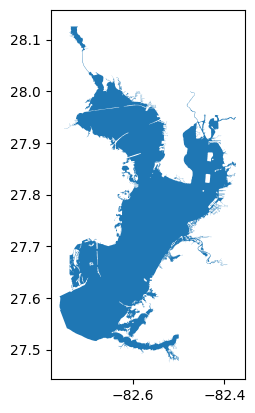

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# geoJSON should be WGS1984 standard, but this one isn't
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] =wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(15517, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

Signature:
location.harmonize_locations(
    df_in,
    out_EPSG=4326,
    intermediate_columns=False,
    **kwargs,
)
Docstring:
Takes a DataFrame with lat/lon in multiple Coordinate Reference Systems,
transforms them to outCRS and converts to GeoDataFrame

Parameters
----------
df_in : pandas.DataFrame
    DataFrame with the required columns to be converted to GeoDataFrame.
out_EPSG : Integer, optional
    EPSG factory code for desired output Coordinate Reference System datum.
    The default is 4326, for the WGS84 Datum used by WQP queries.
intermediate_columns : Boolean, optional
    Return intermediate columns. Default 'False' does not return these.
Keyword Arguments:
crs_col : string, optional
    Name of column in DataFrame with the Coordinate Reference System datum.
    The default is 'HorizontalCoordinateReferenceSystemDatumName'.
lat_col : string, optional
    Name of column in DataFrame with the latitude coordinate.
    The default is 'LatitudeMeasure'.
lon_col : string, opt

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(15517, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed'}

<Axes: >

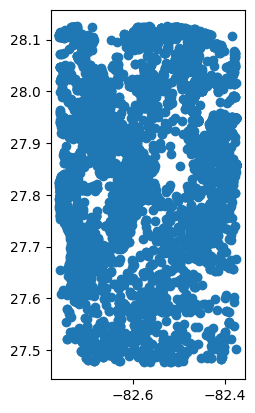

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip it to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

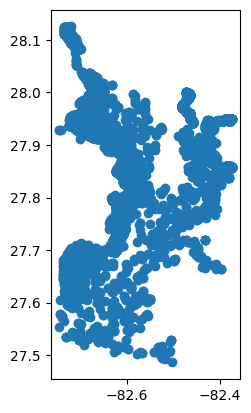

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

10223

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,32,33,36,38,56,57,58,60,61,62,63,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420869,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843062,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1420870,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843065,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1420871,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6894931,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1420872,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6843462,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

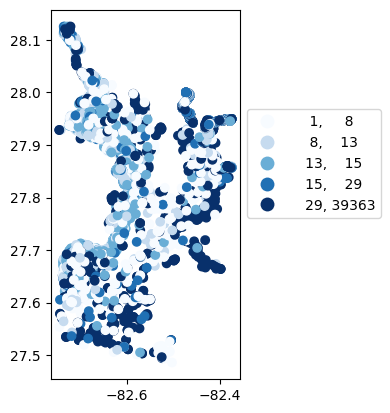

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize_generic?

##### secchi disk depth

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    83345.000000
mean         1.469260
std          0.899706
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 195
Usable results with inferred units: 0
Results outside threshold (0.0 to 6.867499256939849): 45


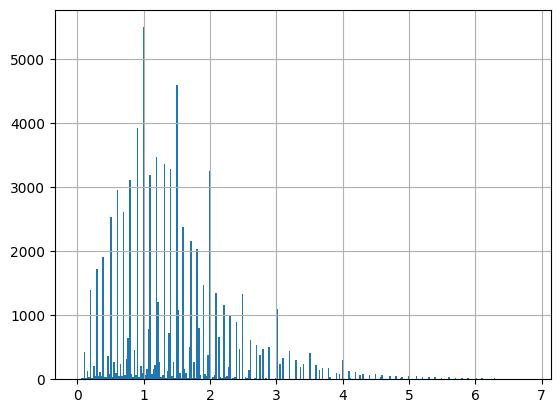

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
36,21FLHILL_WQX-1510,0.80,m,NaN,m,0.8 meter
68,21FLMANA_WQX-428,2.2,m,NaN,m,2.2 meter
96,21FLHILL_WQX-096,2.70,m,NaN,m,2.7 meter
106,21FLHILL_WQX-064,0.80,m,NaN,m,0.8 meter
127,21FLCOSP_WQX-COSPE6-2,1.7,m,NaN,m,1.7 meter
...,...,...,...,...,...,...
1420419,21FLBSG-12,1.3,m,NaN,m,1.3 meter
1420420,21FLBSG-12,1.1,m,NaN,m,1.1 meter
1420437,21FLBSG-12,2.0,m,NaN,m,2.0 meter
1420454,21FLBSG-4,1.1,m,NaN,m,1.1 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
661272,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
664539,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-5,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
667499,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
668497,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-7,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
672688,21FLPDEM_WQX-E2-D-19-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1403567,USGS-273631082452600,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1403895,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1403900,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1404103,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
244344,NARS_WQX-NCCA10-1674,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
661272,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
664539,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-5,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
667499,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
668497,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-7,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1403567,USGS-273631082452600,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1403895,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1403900,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1404103,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
11222,USGS-280630082350900,3,1.966667
11223,USGS-280635082322100,2,2.100000
11224,USGS-280640082434700,3,2.302933
11225,USGS-280719082291400,2,1.000000


C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\mapclassify\classifiers.py:257: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  warnings.warn(


<Axes: >

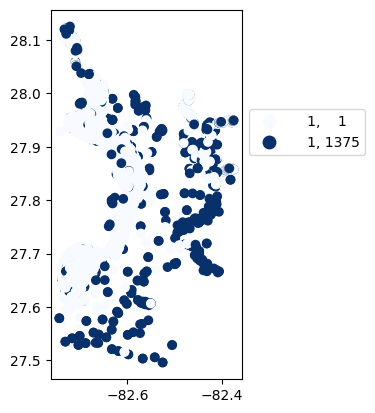

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

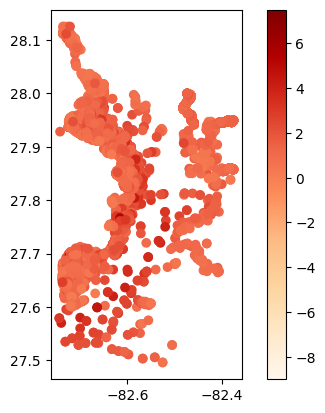

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    292117.000000
mean         25.299194
std          80.972324
min           0.000000
25%          21.200000
50%          25.900000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 112
Usable results with inferred units: 0
Results outside threshold (0.0 to 511.13314048135953): 1


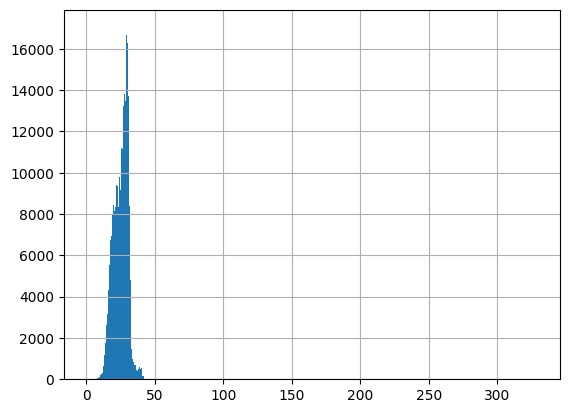

In [32]:
#'Temperature, water'
# Note: Default errors='raise'
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True)

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLHILL_WQX-047,28.19,deg C,NaN,28.19 degree_Celsius,degC
9,21FLTBW_WQX-M23,29.52,deg C,NaN,29.52 degree_Celsius,degC
14,21FLMANA_WQX-GA1,21,deg C,NaN,21.0 degree_Celsius,degC
34,21FLHILL_WQX-1509,27.67,deg C,NaN,27.67 degree_Celsius,degC
37,21FLTBW_WQX-PR103026,17.73,deg C,NaN,17.73 degree_Celsius,degC
...,...,...,...,...,...,...
1420858,USGS-273217082335701,28.9,deg C,NaN,28.9 degree_Celsius,degC
1420861,USGS-274322082245501,24.4,deg C,NaN,24.4 degree_Celsius,degC
1420866,USGS-274302082280801,25.0,deg C,NaN,25.0 degree_Celsius,degC
1420869,USGS-273926082304501,25.7,deg C,NaN,25.7 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
665354,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
666415,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
667812,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
672772,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
678810,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1008321,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1011906,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1304127,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1390313,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
665354,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
666415,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
667812,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
672772,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
678810,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1364476,21FLPDEM_WQX-24-01,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1364899,21FLPDEM_WQX-29-11,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1365432,21FLPDEM_WQX-12-02,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1390313,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [37]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
14347,USGS-280726082313300,4,28.025000
14348,USGS-280728082301101,54,25.083333
14349,USGS-280729082313501,1,27.400000
14350,USGS-280730082313201,1,24.700000


C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\mapclassify\classifiers.py:257: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


<Axes: >

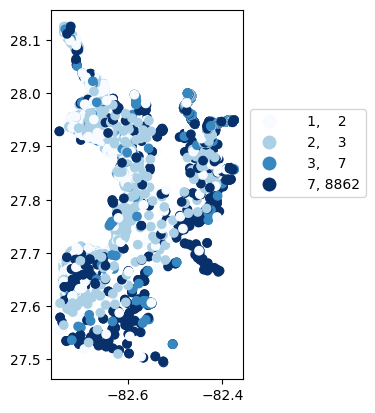

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

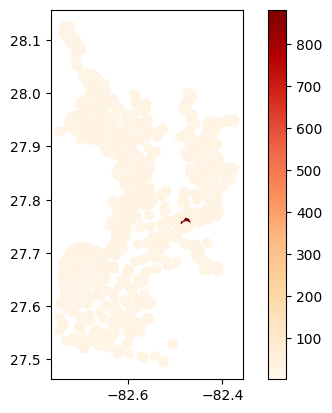

In [39]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved oxygen

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,5.676222371166 milligram / liter
...,...,...,...,...,...
1420574,21FLBSG-4,4.0,mg/l,NaN,4.0 milligram / liter
1420575,21FLBSG-4,7.2,mg/l,NaN,7.2 milligram / liter
1420576,21FLBSG-4,7.4,mg/l,NaN,7.4 milligram / liter
1420577,21FLBSG-4,7.9,mg/l,NaN,7.9 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,5.676222371166 milligram / liter
...,...,...,...,...,...
1382709,21FLHILL_WQX-25,7.1,mg/L,NaN,7.1 milligram / liter
1382711,21FLHILL_WQX-36,7.66,mg/L,NaN,7.66 milligram / liter
1382714,21FLHILL_WQX-14410,3.81,mg/L,NaN,3.81 milligram / liter
1382723,21FLHILL_WQX-40,6.55,mg/L,NaN,6.55 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
12923,NARS_WQX-NCCA10-1672,8,5.437500
12924,NARS_WQX-NCCA10-1673,20,4.115000
12925,NARS_WQX-NCCA10-1674,6,2.466667
12926,NARS_WQX-NLA06608-0161,5,6.500000


C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\mapclassify\classifiers.py:257: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


<Axes: >

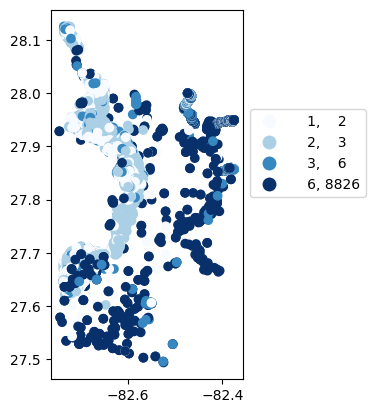

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

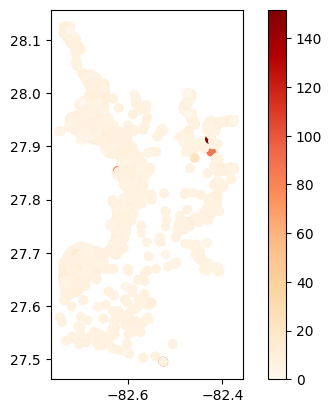

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    268444.000000
mean          7.764112
std           0.471263
min           0.370000
25%           7.530000
50%           7.890000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 129
Usable results with inferred units: 0
Results outside threshold (0.0 to 10.591692727696339): 7


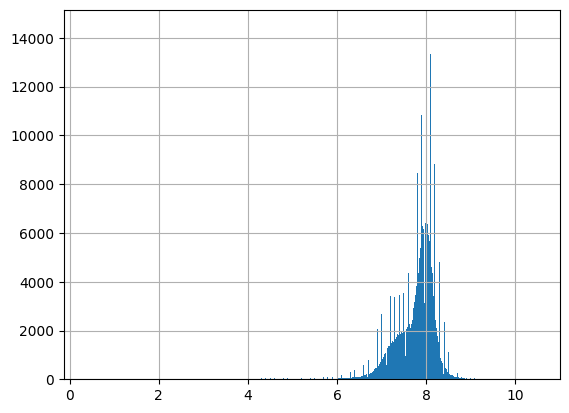

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
4,7.48,None,NaN,7.48 dimensionless
5,8.18,None,NaN,8.18 dimensionless
7,7.81,None,NaN,7.81 dimensionless
11,7.96,None,NaN,7.96 dimensionless
17,7.92,None,NaN,7.92 dimensionless
...,...,...,...,...
1420867,7.9,std units,NaN,7.9 dimensionless
1420868,7.3,std units,NaN,7.3 dimensionless
1420870,7.8,std units,NaN,7.8 dimensionless
1420871,7.7,std units,NaN,7.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    259646.000000
mean         21.831899
std          96.698848
min          -0.020000
25%          18.320000
50%          24.900000
75%          28.700000
max       48930.000000
dtype: float64
Unusable results: 1211
Usable results with inferred units: 0
Results outside threshold (0.0 to 602.0249895588677): 4


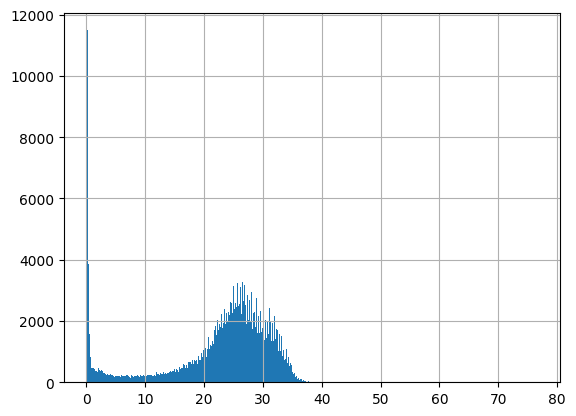

In [48]:
# Salinity
df = harmonize.harmonize_generic(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
1,40,ppth,NaN,40.0 Practical_Salinity_Units
6,29,PSS,NaN,29.0 Practical_Salinity_Units
8,26.04,PSS,NaN,26.04 Practical_Salinity_Units
21,0.18,ppth,NaN,0.18 Practical_Salinity_Units
23,5.9,ppth,NaN,5.9 Practical_Salinity_Units
...,...,...,...,...
1420559,20.5,PSS,NaN,20.5 Practical_Salinity_Units
1420560,21.3,PSS,NaN,21.3 Practical_Salinity_Units
1420562,20.97,PSS,NaN,20.97 Practical_Salinity_Units
1420565,19.9,PSS,NaN,19.9 Practical_Salinity_Units


##### Nitrogen

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579055): 0


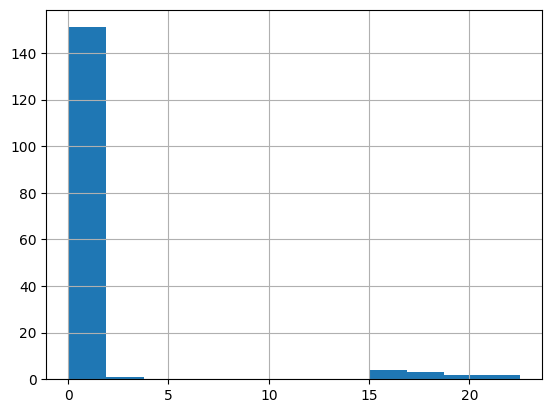

In [50]:
# Nitrogen
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
221555,0.39,mg/L,NaN,0.39 milligram / liter
237688,0.4475,mg/L,NaN,0.4475 milligram / liter
240481,0.425,mg/L,NaN,0.425 milligram / liter
254314,0.4625,mg/L,NaN,0.4625 milligram / liter
255703,0.33625,mg/L,NaN,0.33625 milligram / liter
...,...,...,...,...
1418191,0.084,mg/l,NaN,0.084 milligram / liter
1418199,0.166,mg/l,NaN,0.166 milligram / liter
1418209,0.091,mg/l,NaN,0.091 milligram / liter
1418243,0.057,mg/l,NaN,0.057 milligram / liter


##### Conductivity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     10.000000
mean     703.700000
std       79.037333
min      606.000000
25%      627.750000
50%      731.500000
75%      775.750000
max      776.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 1177.9239977057255): 0


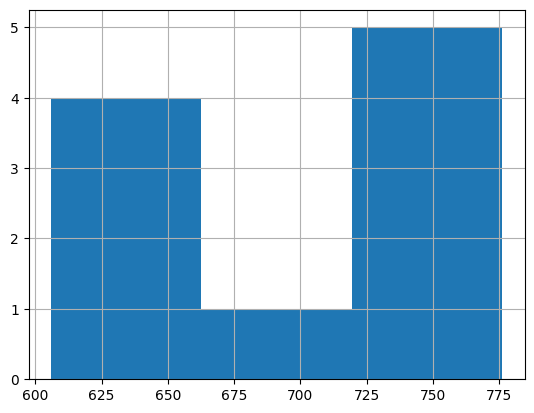

In [52]:
# Conductivity
df = harmonize.harmonize_generic(df, 'Conductivity', report=True)

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
385164,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
389855,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
391293,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
393686,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
394595,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
396383,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
401065,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
417208,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
479538,626,uS/cm,NaN,626.0 microsiemens / centimeter
483898,688,uS/cm,NaN,688.0 microsiemens / centimeter


##### Chlorophyll a

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    43333.000000
mean         0.014368
std          0.022741
min         -0.000506
25%          0.004600
50%          0.008720
75%          0.016360
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.15081314171981786): 197


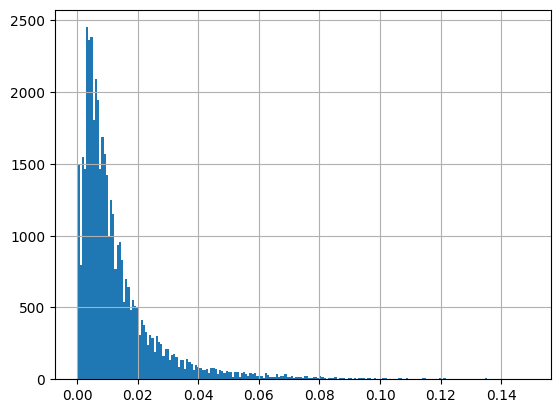

In [54]:
# Chlorophyll a
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
221070,5.94,ug/L,NaN,0.005940000000000001 milligram / liter
226042,1.45,ug/L,NaN,0.00145 milligram / liter
226977,2.77,ug/L,NaN,0.00277 milligram / liter
227828,3.87,ug/L,NaN,0.00387 milligram / liter
235919,8.15,ug/L,NaN,0.008150000000000001 milligram / liter
...,...,...,...,...
1420556,41.09,ug/l,NaN,0.04109 milligram / liter
1420557,57.34,ug/l,NaN,0.05734 milligram / liter
1420564,23.55,ug/l,NaN,0.02355 milligram / liter
1420566,37.07,ug/l,NaN,0.03707 milligram / liter


##### Organic Carbon

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    2.044800e+04
mean     2.597756e+04
std      1.956790e+06
min      0.000000e+00
25%      4.500000e+00
50%      7.100000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1913
Usable results with inferred units: 0
Results outside threshold (0.0 to 11766717.126299601): 8


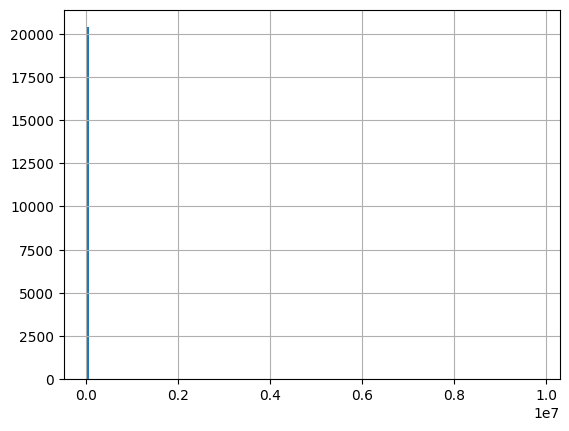

In [56]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/L,NaN,3.8 milligram / liter
124,19.5,mg/L,NaN,19.5 milligram / liter
125,11.3,mg/L,NaN,11.3 milligram / liter
129,6.7,mg/L,NaN,6.7 milligram / liter
135,28.0,mg/L,NaN,28.0 milligram / liter
...,...,...,...,...
1416781,0.83,mg/l,NaN,0.83 milligram / liter
1416831,0.71,mg/l,NaN,0.71 milligram / liter
1416838,1.43,mg/l,NaN,1.43 milligram / liter
1416846,0.9,mg/l,NaN,0.9 milligram / liter


##### Turbidity (NTU)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     89954.000000
mean         16.424991
std         883.385635
min          -0.047700
25%           1.500000
50%           2.400000
75%           4.030000
max      200000.000000
dtype: float64
Unusable results: 1051
Usable results with inferred units: 0
Results outside threshold (0.0 to 5316.738802709647): 155


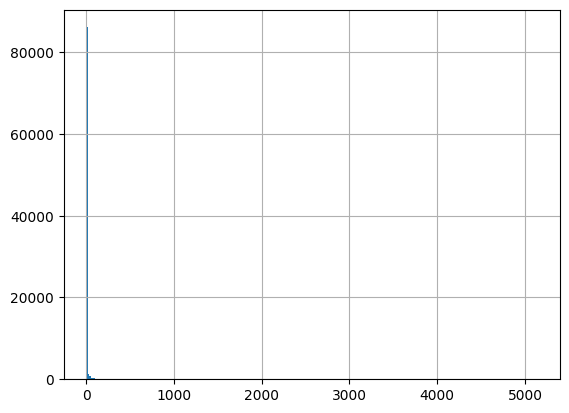

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize_generic(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
25,4.49,NTU,NaN,4.49 Nephelometric_Turbidity_Units
81,1.2,NTU,NaN,1.2 Nephelometric_Turbidity_Units
108,2.9,NTU,NaN,2.9 Nephelometric_Turbidity_Units
147,6.9,NTU,NaN,6.9 Nephelometric_Turbidity_Units
222,4.3,NTU,NaN,4.3 Nephelometric_Turbidity_Units
...,...,...,...,...
1416904,2.3,NTRU,NaN,2.3 Nephelometric_Turbidity_Units
1417001,1.1,NTRU,NaN,1.1 Nephelometric_Turbidity_Units
1417106,0.1,NTRU,NaN,0.1 Nephelometric_Turbidity_Units
1417114,0.7,NTRU,NaN,0.7 Nephelometric_Turbidity_Units


##### Sediment

In [60]:
# Sediment
df = harmonize.harmonize_generic(df, 'Sediment', report=False)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
1383147,28,%,NaN,280.0 gram / kilogram
1383148,38,%,NaN,380.0 gram / kilogram
1403226,97.0,%,NaN,970.0 gram / kilogram
1403227,99.0,%,NaN,990.0 gram / kilogram
1403228,100.0,%,NaN,1000.0 gram / kilogram
1403229,100.0,%,NaN,1000.0 gram / kilogram
1403230,100.0,%,NaN,1000.0 gram / kilogram
1403231,100.0,%,NaN,1000.0 gram / kilogram
1416605,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
df = harmonize.harmonize_generic(df, 'Phosphorus')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
10560,0.004,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
11626,0.053,mg/L,NaN,NaN
...,...,...,...,...
1418488,0.065,mg/l as P,NaN,NaN
1418493,0.027,mg/l as P,NaN,NaN
1418499,0.04,mg/l as P,NaN,NaN
1418514,0.05,mg/l as P,NaN,NaN


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
10560,0.004,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
11626,0.053,mg/L,NaN,NaN
...,...,...,...,...
1418488,0.065,mg/l as P,NaN,NaN
1418493,0.027,mg/l as P,NaN,NaN
1418499,0.04,mg/l as P,NaN,NaN
1418514,0.05,mg/l as P,NaN,NaN


In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
15591,0.003,mg/L,NaN,0.003 milligram / liter
19616,0.050,mg/L,NaN,0.05 milligram / liter
29929,0.009,mg/L,NaN,0.009 milligram / liter
179092,0.050,mg/L,NaN,0.05 milligram / liter
184033,0.002,mg/L,NaN,0.002 milligram / liter
...,...,...,...,...
1413239,0.35,mg/l as P,NaN,0.35 milligram / liter
1413243,0.2,mg/l as P,NaN,0.2 milligram / liter
1413248,0.22,mg/l as P,NaN,0.22 milligram / liter
1413271,0.18,mg/l as P,NaN,0.18 milligram / liter


In [66]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
221875,0.13118375,mg/L,NaN,NaN
238642,0.1696225,mg/L,NaN,NaN
239080,0.0835825,mg/L,NaN,NaN
245371,0.16950375,mg/L,NaN,NaN
255004,0.03524375,mg/L,NaN,NaN
...,...,...,...,...
1395898,0.058,%,NaN,NaN
1396756,0.041,%,NaN,NaN
1397534,0.078,%,NaN,NaN
1416601,460.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count    8.647000e+03
mean     4.903257e+03
std      1.318438e+05
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      6.000000e+01
max      1.000000e+07
dtype: float64
Unusable results: 54828
Usable results with inferred units: 5
Results outside threshold (0.0 to 795966.1242988213): 8


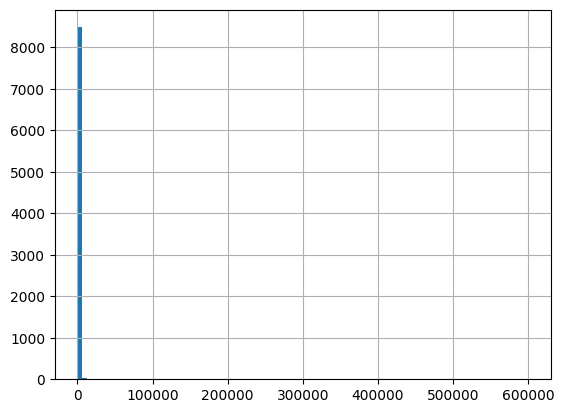

In [67]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True, errors='ignore')

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
13,760,cfu/100mL,NaN,NaN
15,2900,cfu/100mL,NaN,NaN
55,300,#/100mL,NaN,NaN
72,280,#/100mL,NaN,NaN
109,52,cfu/100mL,NaN,NaN
...,...,...,...,...
1416039,8.0,MPN/100ml,NaN,8.0 Colony_Forming_Units / milliliter
1416040,2.0,MPN/100ml,NaN,2.0 Colony_Forming_Units / milliliter
1416041,8.0,MPN/100ml,NaN,8.0 Colony_Forming_Units / milliliter
1416049,49.0,MPN/100ml,NaN,49.0 Colony_Forming_Units / milliliter


###### Excherichia Coli

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count      142.000000
mean       976.669014
std       4473.446618
min          0.000000
25%         21.000000
50%         46.000000
75%        120.000000
max      41000.000000
dtype: float64
Unusable results: 4875
Usable results with inferred units: 0
Results outside threshold (0.0 to 27817.348725062726): 1


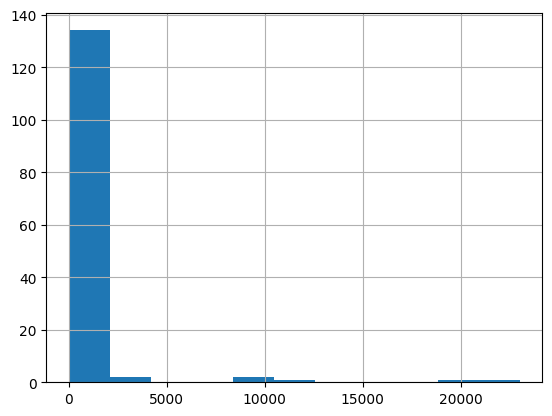

In [69]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
275764,210,MPN/100mL,NaN,NaN
277315,4800,MPN/100mL,NaN,NaN
277566,74.5,MPN/100mL,NaN,NaN
277832,553.9,MPN/100mL,NaN,NaN
278397,87,MPN/100mL,NaN,NaN
...,...,...,...,...
1411892,21.0,cfu/100ml,NaN,21.0 Colony_Forming_Units / milliliter
1411959,10.0,cfu/100ml,NaN,10.0 Colony_Forming_Units / milliliter
1412050,1.0,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter
1412084,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [71]:
from harmonize_wq import convert

In [72]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 259646 
Mean: 21.831898782958255 PSU


In [73]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [74]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [75]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
288110,48930,ppth,NaN,48930.0 Practical_Salinity_Units
434409,76.57,ppth,NaN,76.57 Practical_Salinity_Units
497277,54.8,ppth,NaN,54.8 Practical_Salinity_Units
620699,2976,ppth,NaN,2976.0 Practical_Salinity_Units
645780,68,ppth,NaN,68.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [76]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [77]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
25648,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
25649,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
46164,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
46165,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
373948,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
551938,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
561266,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
736817,-0.02,ppth,NaN,-0.02 Practical_Salinity_Units,NaN,NaN,NaN,NaN
923444,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
926281,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [78]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

481645    626.0 microsiemens / centimeter
486030    688.0 microsiemens / centimeter
503531    606.0 microsiemens / centimeter
504653    606.0 microsiemens / centimeter
507894    633.0 microsiemens / centimeter
577326    775.0 microsiemens / centimeter
580001    776.0 microsiemens / centimeter
580999    776.0 microsiemens / centimeter
583061    776.0 microsiemens / centimeter
588690    775.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [79]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
580001,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
580999,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
583061,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
577326,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
588690,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
486030,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
507894,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter
481645,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter
503531,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter
504653,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter


In [80]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

580001    0.379 dimensionless
580999    0.379 dimensionless
583061    0.379 dimensionless
577326    0.379 dimensionless
588690    0.379 dimensionless
486030    0.335 dimensionless
507894    0.308 dimensionless
481645    0.304 dimensionless
503531    0.294 dimensionless
504653    0.294 dimensionless
Name: Salinity, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [81]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
580001,2007-08-15,NaN,NaN
580999,2007-08-15,NaN,NaN
583061,2007-08-15,NaN,NaN
577326,2007-08-15,NaN,NaN
588690,2007-08-15,NaN,NaN
...,...,...,...
1424513,1955-04-08,NaN,NaN
1424514,1955-04-08,NaN,NaN
1424515,1957-10-21,14:05:00,EST
1424516,1955-04-08,NaN,NaN


In [82]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 100662 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
580001,2007-08-15,NaT
580999,2007-08-15,NaT
583061,2007-08-15,NaT
577326,2007-08-15,NaT
588690,2007-08-15,NaT
...,...,...
1424513,1955-04-08,NaT
1424514,1955-04-08,NaT
1424515,1957-10-21,1957-10-21 19:05:00+00:00
1424516,1955-04-08,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [83]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


486030     0.95
507894     0.50
481645     0.00
377629     0.10
378223     0.10
           ... 
1006048    0.43
1009711    0.38
1012084    0.43
1013230    0.38
1013561    0.33
Name: ResultDepthHeightMeasure/MeasureValue, Length: 261, dtype: float64

#### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Salinity,QA_Nitrogen,QA_E_coli,QA_Temperature,QA_Secchi,QA_DO,QA_Carbon
580001,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
580999,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583061,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201135,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577326,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201115,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
588690,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:0,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-183201107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424513,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843062,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1424514,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843065,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1424515,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,-0500,USGS-02306001,NWIS-6894931,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1424516,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6843462,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

66404 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'Conductivity', 'Chlorophyll', 'Carbon', 'Turbidity',
       'Sediment', 'Phosphorus', 'TP_Phosphorus', 'TDP_Phosphorus',
       'Other_Phosphorus', 'Fecal_Coliform', 'E_coli',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Sediment', 'QA_Conductivity',
       'QA_Fecal_Coliform', 'QA_Turbidity', 'QA_Chlorophyll', 'QA_pH',
       'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Salinity', 'QA_Nitrogen', 'QA_E_coli', 'QA_Temperature',
       'QA_Secchi', 'QA_DO', 'QA_Carbon'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Salinity,QA_Nitrogen,QA_E_coli,QA_Temperature,QA_Secchi,QA_DO,QA_Carbon
580001,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
580999,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583061,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577326,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
588690,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:0,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['QA_Sediment',
 'QA_Conductivity',
 'QA_Turbidity',
 'QA_pH',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Salinity',
 'QA_Nitrogen',
 'QA_E_coli',
 'QA_Temperature',
 'QA_DO',
 'QA_Carbon']

<Axes: >

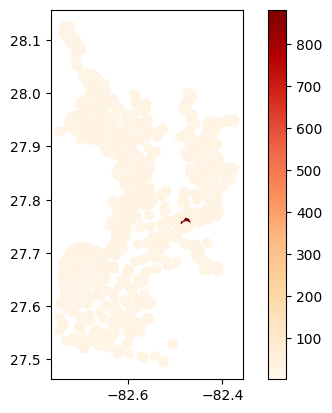

In [92]:
# Map average temperature at each station
results_gdf = visualize.map_measure(main_df, stations_clipped, 'Temperature')
results_gdf.plot(column='mean', cmap='OrRd', legend=True)